# Interpretability of autoencoder latent space for passengers demand-sensitive planning on high-speed railways (IWANN 2023)


In [2]:
import datetime
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf

from feature_engine.creation import CyclicalFeatures
from IPython.display import display
from nltk.corpus import wordnet
from numpy.random import seed
from scipy import spatial
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from typing import Dict, List, Tuple

from src.robin.supply.entities import Supply

SEED = 10

os.environ['PYTHONHASHSEED'] = str(SEED)  # Set python hash seed
np.random.seed(SEED)  # Set numpy random seed
random.seed(SEED)  # Set random seed
tf.random.set_seed(SEED)  # Set tensorflow random seed

SAVE_PATH = '../reports/figures/ae_interpretability/'

if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

2023-06-08 18:41:21.569406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Download wordnet if not already downloaded
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/david/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
def get_paths_from_supply(path_config_supply: str = '../configs/test_case/supply_data.yml') -> List[List[str]]:
    """
    Get the paths of a supply

    Args:
        path_config_supply (str, optional): Path to the supply config file. Defaults to '../configs/test_case/supply_data.yml'.

    Returns:
        List[List[str]]: List of paths
    """
    supply = Supply.from_yaml(path_config_supply)

    # Get set of corridors
    corridors = []
    for service in supply.services:
        if service.line.corridor not in corridors:
            corridors.append(service.line.corridor)

    # Get set of paths
    paths = []
    for corridor in corridors:
        for path in corridor.paths:
            if path not in paths:
                paths.append(path)

    # Parse paths of Station objects to paths of station mame
    paths = [[station.name.replace("-", " ").split(" ")[0].lower() for station in path] for path in paths]
    return paths

paths = get_paths_from_supply()
print(paths)

[['madrid', 'guadalajara', 'calatayud', 'zaragoza', 'lleida', 'tarragona', 'barcelona', 'girona', 'figueres']]


In [5]:
def get_random_pair(paths: list[list]) -> Tuple[str, str]:
    """
    Get a random pair of stations from a path

    Args:
        paths (list[list]): List of stations

    Returns:
        Tuple[str, str]: Tuple with the origin and destination stations
    """
    random_path = random.choice(paths)  # Choose a random path

    origin_index = random.randint(0, len(random_path) - 2)  # Choose a random origin station
    destination_index = random.randint(origin_index + 1, len(random_path) - 1)  # Choose a random destination station

    origin_station = random_path[origin_index]
    destination_station = random_path[destination_index]
    return origin_station, destination_station

In [6]:
def get_renfe_station_id(adif_id: str, stations_df: pd.DataFrame) -> str:
    """
    Returns the Station name given the Adif station id.

    Args:
        adif_id (str): Adif station id.
        stations_df (pd.DataFrame): Dataframe with the stations' information.

    Returns:
        str: Station name.
    """
    station_name = stations_df[stations_df['stop_id'] == adif_id]['stop_name'].values[0]
    station_name = station_name.replace("-", " ").split(" ")[0].lower()
    return station_name

stations_csv_path = f'../data/renfe/renfe_stations.csv'
stations_df = pd.read_csv(stations_csv_path, dtype={'stop_id': str, 'renfe_id': str})

In [7]:
def simulate_passengers_data(paths: list,
                             user_patterns: list,
                             n_passengers: int = 10000,
                             seed: int = 42
    ) -> pd.DataFrame:
    # Set random state
    random.seed(seed)

    pairs = []
    for _ in range(n_passengers):
        pairs.append(get_random_pair(paths))

    df = pd.DataFrame(pairs, columns=['origin', 'destination'])
    df['user_pattern'] = [random.choice(user_patterns) for _ in range(n_passengers)]

    random_days = lambda: random.randint(0, 365*10)
    random_hours = lambda: random.randint(0, 24)
    random_minutes = lambda: random.randint(0,60)

    random_timedelta = lambda: datetime.timedelta(days=random_days(), hours=random_hours(), minutes=random_minutes())
    df['date'] = [datetime.datetime(2021, 1, 1) + random_timedelta() for _ in range(n_passengers)]
    return df

user_patterns = ("business", "student", "tourist")
df = simulate_passengers_data(paths, user_patterns, n_passengers=10000)

display(df.head())

,origin,destination,user_pattern,date
0,madrid,tarragona,tourist,2027-05-03 14:39:00
1,zaragoza,tarragona,business,2028-01-04 23:52:00
2,guadalajara,barcelona,business,2027-08-13 01:46:00
3,madrid,guadalajara,student,2028-08-30 07:48:00
4,zaragoza,tarragona,student,2029-08-27 04:15:00


In [8]:
class AutoencoderEmbedding:
    """
    Class to get the embedding of a dataframe to be used as input of an autoencoder

    Attributes:
        df (pd.DataFrame): Dataframe with the data to be embedded
        df_embedding (pd.DataFrame): Dataframe with the embedding.
        embedding_dim (int, optional): Embedding dimension. Defaults to 50.
        embedding_dict (dict): Dictionary with the embedding.
        scaler (MinMaxScaler): Scaler to normalize the data.
        cyclical (CyclicalFeatures): Cyclical features transformer.
        df_time (pd.DataFrame): Dataframe with the time embedding.
        input_arrays (list[np.array]): List of arrays with the embedded input data.
    """
    def __init__(self, df: pd.DataFrame, embedding_dim: int = 50, noise: bool = True):
        """
        Constructor method

        Args:
            df (pd.DataFrame): Dataframe with the data to be embedded
            embedding_dim (int, optional): Embedding dimension. Defaults to 50.
        """
        self.df = df
        self.scaler = MinMaxScaler(feature_range=(-2, 2))
        self.df_time = self._get_datetime_df()
        self.noise = noise
        self.embedding_dim = embedding_dim
        # self.cyclical = CyclicalFeatures(variables=['time'], drop_original=True)
        if self.noise:
            self.df_noisy = self._get_noisy_df()

        df_bag_words = pd.concat([self.df_noisy, self.df], ignore_index=True) if self.noise else self.df
        words_set = set(df_bag_words[['origin', 'destination', 'user_pattern']].values.flatten())
        self.word_index = {word: index for index, word in enumerate(words_set)}
        self.embedding_dict = self._get_embedding_dict()

        if self.noise:
            self.df_embedding_noisy = self._get_embedding_df(self.df_noisy)
            self.embedding_noisy_arrays = self._get_embedding_arrays(self.df_embedding_noisy)
        self.df_embedding = self._get_embedding_df(self.df)
        self.embedding_arrays = self._get_embedding_arrays(self.df_embedding)

    def _get_datetime_df(self) -> pd.DataFrame:
        """
        Get time features dataframe.

        Returns:
            pd.DataFrame: Dataframe with the time features.
        """
        def encode(data, column, max_val: int,  zero_index: bool = False):
            if not zero_index:
                data[column] -= 1
            data[column + '_sin'] = np.sin(2 * np.pi * data[column]/max_val)
            data[column + '_cos'] = np.cos(2 * np.pi * data[column]/max_val)
            return data

        df_datetime = pd.DataFrame()
        df_datetime['month'] = self.df['date'].dt.month
        df_datetime = encode(df_datetime, 'month', max_val=12)
        df_datetime['day'] = self.df['date'].dt.day
        df_datetime = encode(df_datetime, 'day', max_val=31)
        df_datetime['minutes'] = self.df['date'].dt.hour * 60 + self.df['date'].dt.minute
        df_datetime = encode(df_datetime, 'minutes', max_val = 24*60, zero_index=True)

        cyclical_cols = ['month_cos', 'month_sin', 'day_cos', 'day_sin', 'minutes_cos', 'minutes_sin']
        df_datetime[cyclical_cols] = self.scaler.fit_transform(df_datetime[cyclical_cols])

        return df_datetime

    def _get_embedding_arrays(self, df: pd.DataFrame) -> np.array:
        """
        Get the words embedding.

        Args:
            df (pd.DataFrame, optional): Dataframe with the data to be embedded. Defaults to None.

        Returns:
            np.array: Array with the words embedding.
        """
        input_data = df[['origin', 'destination', 'user_pattern', 'date']].values.tolist()
        return np.array([np.asarray(row, dtype=np.float32) for row in input_data])

    def _get_embedding_dict(self) -> Dict[str, np.array]:
        """
        Get the words embedding dictionary

        Returns:
            Dict[str, np.array]: Dictionary with the embedding.
        """
        embeddings_index = {}
        f = open(os.path.join('../data/pretrained/glove6B/glove.6B.50d.txt'))

        # Read GloVe embeddings
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype=np.float32)
            embeddings_index[word] = coefs
        f.close()

        # Create embedding matrix
        embedding_matrix = np.zeros((len(self.word_index) + 1, self.embedding_dim))
        embedding_dict = {}
        for word, i in self.word_index.items():
            embedding_vector = embeddings_index.get(word, np.zeros(self.embedding_dim))
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                embedding_dict[word] = embedding_vector

        return embedding_dict

    def decode_time_embedding(self, encoded_time_vector):

        def decode(val_cos, val_sin, max_val, zero_index: bool = False) -> int:
            angle = np.arctan2(val_sin, val_cos)
            val = (angle / (2 * np.pi)) * max_val
            val = int(round(val) % max_val)
            if not zero_index:
                return val + 1
            return val

        encoded_time_vector = self.scaler.inverse_transform(encoded_time_vector[:8])[0]
        month = decode(encoded_time_vector[0], encoded_time_vector[1], max_val=12)
        day = decode(encoded_time_vector[2], encoded_time_vector[3], max_val=31)
        minutes = decode(encoded_time_vector[4], encoded_time_vector[5], max_val=24*60, zero_index=True)
        hour = minutes // 60
        minute = minutes % 60
        return month, day, hour, minute

    def get_word_syn(self, word: str) -> str:
        """
        Get a random synonym of a word

        Args:
            word (str): Word to get the synonym from

        Returns:
            str: Synonym of the word
        """
        word_synset = wordnet.synsets(word)
        if len(word_synset) > 0:
            station_synset = word_synset[0]
            station_lemmas = station_synset.lemmas()
            if len(station_lemmas) > 0:
                word_lemma = random.choice(station_lemmas)
                return word_lemma.name().lower()

        return word

    def _get_noisy_df(self, p: float = 0.2) -> pd.DataFrame:
        """
        Get the noisy embedding dataframe by replacing some of the words with synonyms

        Returns:
            pd.DataFrame: Noisy embedding dataframe.
        """
        df_noisy = self.df.copy()
        df_noisy['origin'] = df_noisy['origin'].apply(lambda x: self.get_word_syn(x) if random.random() < p else x)
        df_noisy['destination'] = df_noisy['destination'].apply(lambda x: self.get_word_syn(x) if random.random() < p else x)
        df_noisy['user_pattern'] = df_noisy['user_pattern'].apply(lambda x: self.get_word_syn(x) if random.random() < p else x)

        return df_noisy

    def _get_embedding_df(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Get embedding dataframe.

        Returns:
            pd.DataFrame: Embedding dataframe.
        """
        df_embedding = df.copy()
        df_embedding['origin'] = df_embedding['origin'].apply(lambda x: self.embedding_dict.get(x))
        df_embedding['destination'] = df_embedding['destination'].apply(lambda x: self.embedding_dict.get(x))
        df_embedding['user_pattern'] = df_embedding['user_pattern'].apply(lambda x: self.embedding_dict.get(x))
        df_embedding['date'] = self.df_time[['month_cos',
                                               'month_sin',
                                               'day_cos',
                                               'day_sin',
                                               'minutes_cos',
                                               'minutes_sin']].apply(lambda row: np.array(row), axis=1)

        df_embedding['date'] = df_embedding['date'].apply(lambda x: np.pad(x, (0, self.embedding_dim - len(x)), 'constant', constant_values=np.float32(0.0)))
        return df_embedding[['origin', 'destination', 'user_pattern', 'date']]

In [9]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

EMBEDDING_DIM = 50

print("Train data shape: ", df_train.shape)
print("Test data shape: ", df_test.shape)

train_embedding = AutoencoderEmbedding(df = df_train, embedding_dim=EMBEDDING_DIM)
test_embedding = AutoencoderEmbedding(df = df_test, embedding_dim=EMBEDDING_DIM, noise=False)

print("Header of train data:")
display(train_embedding.df.head())

print("Header of test data:")
display(test_embedding.df.head())

Train data shape:  (7000, 4)
Test data shape:  (3000, 4)
Header of train data:


,origin,destination,user_pattern,date
9069,tarragona,girona,student,2029-02-27 19:38:00
2603,zaragoza,girona,tourist,2030-08-31 09:54:00
7738,lleida,figueres,tourist,2026-06-20 08:14:00
1579,zaragoza,figueres,student,2021-02-20 00:04:00
5058,zaragoza,lleida,student,2027-01-26 09:35:00


Header of test data:


,origin,destination,user_pattern,date
6252,zaragoza,lleida,student,2027-06-13 22:10:00
4684,girona,figueres,tourist,2030-06-01 23:10:00
1731,guadalajara,figueres,business,2027-07-16 04:05:00
4742,guadalajara,girona,student,2021-01-19 17:26:00
4521,madrid,figueres,student,2024-05-21 10:39:00


## Autoencoder model

In [10]:
def custom_loss(y_true, y_pred):
    # Split last array in sub_arrays of size 2
    true_segments = tf.split(y_true[:, -1], num_or_size_splits=[2, 2, 2, EMBEDDING_DIM-6], axis=1)
    pred_segments = tf.split(y_pred[:, -1], num_or_size_splits=[2, 2, 2, EMBEDDING_DIM-6], axis=1)

    # Calculate difference between true and predicted segments
    segment_losses = [K.square(true_segment - pred_segment) for true_segment, pred_segment in zip(true_segments, pred_segments)]

    # Calculate MSE loss for the first 3 arrays
    mse_loss = K.mean(K.square(y_true[:, :-1] - y_pred[:, :-1]))

    # Calculate weighted loss for the last array
    # Weights for latent space = 5, batch_size = 64, epochs = 60: [5e-4, 5.5e-4, 4e-4, 0]
    # Weights for latent space = 5, batch_size = 64, epochs = 60: [3.7e-4, 4.2e-4, 2.7e-4, 0]
    segment_weights = [3.7e-4, 4.2e-4, 2.7e-4, 0]
    weighted_losses = [segment_loss * weight for segment_loss, weight in zip(segment_losses, segment_weights)]

    # Sum all losses
    loss = mse_loss + K.sum(K.concatenate(weighted_losses, axis=1))

    return loss

In [11]:
SEQUENCE_LENGTH = 4
embedding_shape = (SEQUENCE_LENGTH, EMBEDDING_DIM)

latent_dim = 5

# Encoder model
encoder_input = Input(shape=embedding_shape)

conv1 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(encoder_input)
conv2 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(conv1)
pooling = GlobalMaxPooling1D()(conv2)
flat_layer = Flatten()(pooling)

encoder = Dense(64)(flat_layer)
encoder = Dense(32)(encoder)

dense1 = Dense(latent_dim, activation='tanh')(encoder)

# Decoder model
decoder_inputs = Input(shape=(latent_dim,))
dense3 = Dense(32)(decoder_inputs)
dense4 = Dense(64)(dense3)

dense5 = Dense(32 * SEQUENCE_LENGTH, activation='relu')(dense4)
decoder = Reshape((SEQUENCE_LENGTH, 32))(dense5)
decoder = Conv1DTranspose(32, kernel_size=3, activation='relu', padding='same')(decoder)
decoder = Conv1DTranspose(64, kernel_size=3, activation='relu', padding='same')(decoder)
decoder_output = Conv1DTranspose(EMBEDDING_DIM, kernel_size=3, padding='same')(decoder)

encoder_model = Model(inputs=encoder_input, outputs=dense1)
encoder_model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

decoder_model = Model(inputs=decoder_inputs, outputs=decoder_output)
decoder_model.compile(optimizer='adam', loss=custom_loss, metrics=[tf.keras.metrics.MeanSquaredError()])

model = Model(inputs=encoder_input, outputs=decoder_model(dense1))

model.compile(optimizer='adam', loss=custom_loss)
model.summary()

2023-06-08 18:41:40.104369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 50)]           0         
                                                                 
 conv1d (Conv1D)             (None, 4, 64)             9664      
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 32)             6176      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                           

In [12]:
history = model.fit(x = train_embedding.embedding_arrays,
                    y = train_embedding.embedding_arrays,
                    epochs=60,
                    batch_size=64,
                    verbose=1)

Epoch 1/60
110/110 [==============================] - 2s 3ms/step - loss: 0.4617
Epoch 2/60
110/110 [==============================] - 0s 4ms/step - loss: 0.3665
Epoch 3/60
110/110 [==============================] - 0s 4ms/step - loss: 0.3459
Epoch 4/60
110/110 [==============================] - 1s 5ms/step - loss: 0.2895
Epoch 5/60
110/110 [==============================] - 0s 4ms/step - loss: 0.2571
Epoch 6/60
110/110 [==============================] - 0s 4ms/step - loss: 0.2243
Epoch 7/60
110/110 [==============================] - 0s 4ms/step - loss: 0.2116
Epoch 8/60
110/110 [==============================] - 0s 4ms/step - loss: 0.2014
Epoch 9/60
110/110 [==============================] - 0s 4ms/step - loss: 0.1910
Epoch 10/60
110/110 [==============================] - 1s 5ms/step - loss: 0.1834
Epoch 11/60
110/110 [==============================] - 1s 6ms/step - loss: 0.1774
Epoch 12/60
110/110 [==============================] - 1s 7ms/step - loss: 0.1698
Epoch 13/60
110/110 [====

In [13]:
history.history.keys()

dict_keys(['loss'])

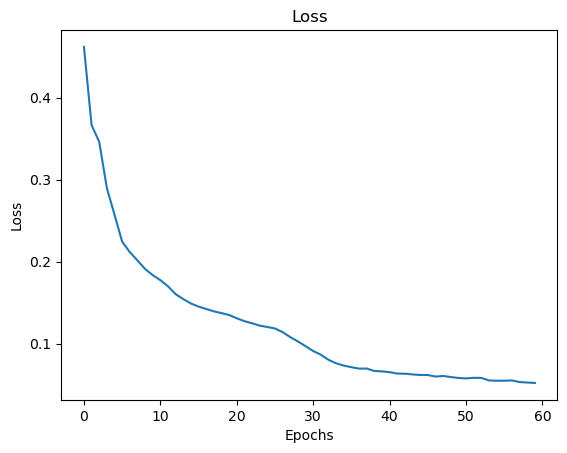

In [14]:
# Plot history loss
plt.plot(history.history['loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [15]:
# Evaluate model
score = model.evaluate(x=test_embedding.embedding_arrays,
                       y=test_embedding.embedding_arrays,
                       verbose=1)

94/94 [==============================] - 0s 2ms/step - loss: 0.0528


## Make predictions

In [16]:
def find_closest_embeddings(embedding, emb):
    return sorted(emb.keys(), key=lambda word: spatial.distance.euclidean(emb[word], embedding))[0]

In [17]:
random_index = np.random.randint(0, test_embedding.df.shape[0])

random_embedding = test_embedding.embedding_arrays[random_index:random_index+1]

print("Input - Random passenger data: ")
print(test_embedding.df.iloc[random_index])

prediction = model.predict(x = random_embedding)

#print(prediction)

print("Output - Passenger reconstruction: ")
origin, destination, user_type = [find_closest_embeddings(word_vector, test_embedding.embedding_dict) for word_vector in prediction[0][:3]]
print(f"Origin: {origin}")
print(f"Destination: {destination}")
print(f"User type: {user_type}")

print("Time prediction: ")
month, day, hour, minute = test_embedding.decode_time_embedding(np.array([prediction[0][-1][:6]]))
print(f"Date: 0000-{month}-{day} {hour}:{minute}")

Input - Random passenger data: 
origin                    calatayud
destination               tarragona
user_pattern               business
date            2029-07-31 23:16:00
Name: 4534, dtype: object
1/1 [==============================] - 0s 192ms/step
Output - Passenger reconstruction: 
Origin: calatayud
Destination: tarragona
User type: business
Time prediction: 
Date: 0000-7-31 23:36


## Estudio de la correlación entre factores latentes y la entrada del autoencoder

In [18]:
# Latent space for test data
latent_space = encoder_model.predict(x = test_embedding.embedding_arrays)

94/94 [==============================] - 0s 1ms/step


In [19]:
# Get set of values in origin column
origin_values = set(test_embedding.df['origin'].values)

# Get dict of origin values and their corresponding GloVe embedding value
origin_embedding_dict = {}
for value in origin_values:
    origin_embedding_dict[value] = test_embedding.embedding_dict[value]

print(origin_embedding_dict)

# Get dict with origin values and distance
total_distance = 0
prev_embedding = None
distances_dict = {}
for i, (value, embedding) in enumerate(origin_embedding_dict.items()):
    if i == 0:
        distances_dict[value] = np.float32(0.0)
        prev_embedding = embedding
        continue

    distance = spatial.distance.euclidean(prev_embedding, embedding)
    total_distance += distance
    distances_dict[value] = distance
    prev_embedding = embedding

print(distances_dict)

{'zaragoza': array([ 1.0642  ,  0.089939, -0.28715 ,  0.82471 ,  0.31063 , -1.4798  ,
        0.12028 ,  0.7449  , -1.2919  ,  0.39737 ,  0.4715  , -0.53483 ,
       -0.48049 , -1.2998  ,  0.32826 , -1.3085  , -0.67916 , -0.20625 ,
       -0.7232  ,  0.41638 , -1.2895  , -0.69963 , -0.23631 ,  0.70175 ,
       -0.61498 ,  0.20193 ,  1.329   ,  0.25294 , -0.093715, -0.16535 ,
        0.99605 ,  1.2007  , -0.26729 , -0.42035 , -0.15881 ,  0.63906 ,
       -0.73977 ,  1.3119  ,  0.61136 , -0.59197 ,  1.3032  ,  0.16094 ,
       -0.027686, -0.9412  , -0.68288 ,  0.65116 ,  0.47976 , -0.32516 ,
        1.3912  , -0.50467 ], dtype=float32), 'girona': array([ 0.69573 ,  0.16443 , -0.61718 , -0.13909 , -1.2492  , -0.47829 ,
        0.50206 ,  1.0136  , -1.0403  ,  1.1929  ,  1.3871  , -0.88079 ,
        0.54227 , -0.90985 , -0.1475  , -0.18127 , -0.35494 ,  0.63054 ,
        0.1464  ,  1.1372  , -0.71314 , -0.61257 , -0.44408 ,  1.2782  ,
       -0.1732  ,  0.30406 , -0.30278 ,  0.071796, -0.4

In [20]:


col_distances = test_embedding.df['origin'].apply(lambda x: distances_dict[x]).values

for j in range(latent_dim):
    lf = latent_space[:, j]
    # Get Pearson correlation between latent factor and distance
    corr, _ = pearsonr(lf, col_distances)
    print(f"Latent factor {j+1} - Pearson correlation: {corr}")

Latent factor 1 - Pearson correlation: -0.00781289805763414
Latent factor 2 - Pearson correlation: 0.006813941897190899
Latent factor 3 - Pearson correlation: -0.02258389794279462
Latent factor 4 - Pearson correlation: 0.00021389649783964005
Latent factor 5 - Pearson correlation: 0.013500198983578108


[]

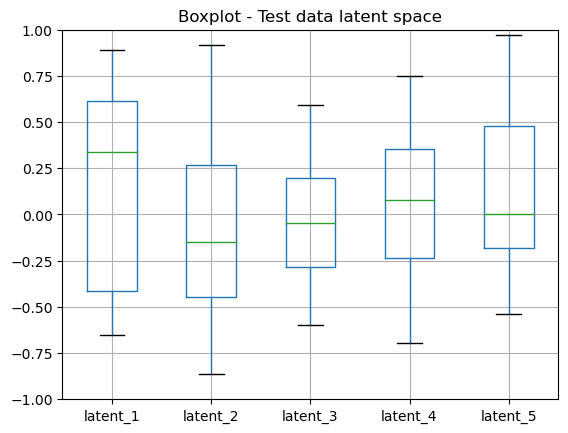

In [21]:
# Box Plot
df_predictions = pd.DataFrame(latent_space, columns = [f"latent_{i}" for i in range(1, latent_space.shape[1]+1)])

b_plot = df_predictions.boxplot()
plt.ylim(-1, 1)

plt.title("Boxplot - Test data latent space")
plt.savefig(SAVE_PATH + "boxplot_test_data.png", dpi=300)
b_plot.plot()

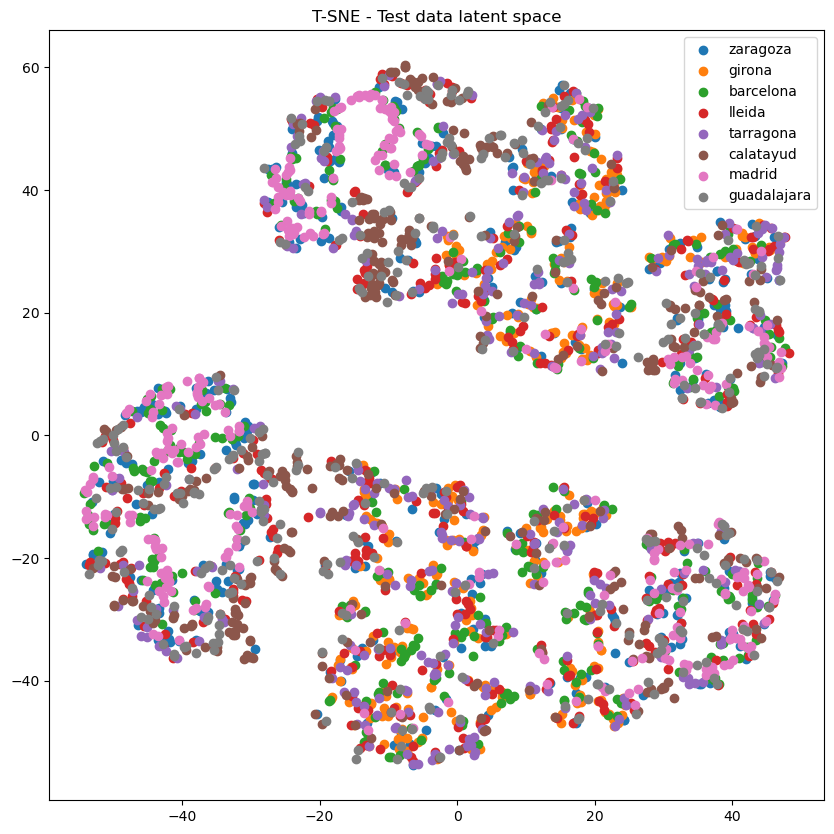

In [24]:
# T-SNE

def tsne_plot(latent_space: np.array,
              ae_embedding: AutoencoderEmbedding,
              column: str,
              title: str,
              file_name: str
    ) -> None:
    tsne = TSNE(n_components=2, random_state=SEED)
    tsne_latent_space = tsne.fit_transform(latent_space)

    # Scatter plot tsne_latent_space
    plt.figure(figsize=(10, 10))
    plt.title(title)

    values_set = set(ae_embedding.df[column].values)
    for i, value in enumerate(values_set):
        plt.scatter(tsne_latent_space[ae_embedding.df[column] == value, 0],
                    tsne_latent_space[ae_embedding.df[column] == value, 1],
                    label=value)
    plt.legend()
    plt.savefig(SAVE_PATH + file_name, dpi=300, bbox_inches='tight')
    plt.show()

tsne_plot(latent_space=latent_space,
          ae_embedding=test_embedding,
          column='origin',
          title="T-SNE - Test data latent space",
          file_name="tsne_test_data")

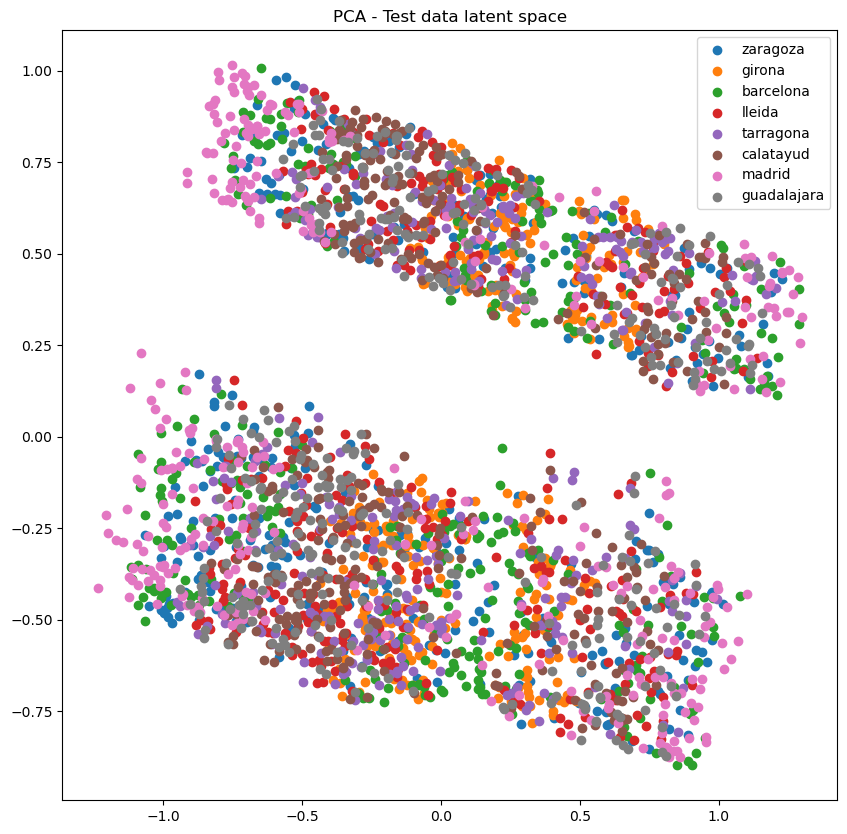

In [26]:
# PCA on latent space to analyze relationship between latent factors and input variables

def pca_plot(latent_space: np.array,
             ae_embedding: AutoencoderEmbedding,
             column: str,
             title: str,
             file_name: str
    ) -> None:
    pca = PCA(n_components=2, random_state=SEED)
    pca_latent_space = pca.fit_transform(latent_space)

    # Scatter plot pca_latent_space with legend of origin
    plt.figure(figsize=(10, 10))
    plt.title(title)

    values_set = set(ae_embedding.df[column].values)
    for i, value in enumerate(values_set):
        plt.scatter(pca_latent_space[ae_embedding.df[column] == value, 0],
                    pca_latent_space[ae_embedding.df[column] == value, 1],
                    label=value)

    plt.legend()
    plt.savefig(SAVE_PATH + file_name, dpi=300, bbox_inches='tight')
    plt.show()

pca_plot(latent_space=latent_space,
         ae_embedding=test_embedding,
         column='origin',
         title="PCA - Test data latent space",
         file_name="pca_test_data")

## Test data analysis with locked columns

In [27]:
def get_locked_dataframe(df: pd.DataFrame,
                         locked_columns: list,
                         seed: int = 18
    ) -> pd.DataFrame:
    """
    Get a dataframe with locked columns (all rows with the same value)

    Args:
        df (pd.DataFrame): Dataframe to lock
        locked_columns (list): List of columns to lock
        seed (int): Random seed

    Returns:
        pd.DataFrame: Locked dataframe
    """
    random.seed(seed)
    df_locked = df.copy()

    for column in locked_columns:
        values = tuple(set(df_locked[column].values))
        locked_value = random.sample(values, 1)[0]
        df_locked[column] = locked_value

    return df_locked

locked_dataframe = get_locked_dataframe(df=test_embedding.df,
                                        locked_columns=['destination', 'user_pattern', 'date'])

locked_embedding = AutoencoderEmbedding(df=locked_dataframe, embedding_dim=EMBEDDING_DIM, noise=False)
display(locked_embedding.df.head())

# Get latent space of the locked_embedding
latent_space = encoder_model.predict(x = locked_embedding.embedding_arrays)

# Get range of values for each latent factor
latent_space_range = pd.DataFrame(latent_space).describe().loc[['min', 'max']]

print("Latent space range: ")
print(latent_space_range)

,origin,destination,user_pattern,date
6252,zaragoza,figueres,tourist,2029-12-30 17:06:00
4684,girona,figueres,tourist,2029-12-30 17:06:00
1731,guadalajara,figueres,tourist,2029-12-30 17:06:00
4742,guadalajara,figueres,tourist,2029-12-30 17:06:00
4521,madrid,figueres,tourist,2029-12-30 17:06:00


94/94 [==============================] - 0s 1ms/step
Latent space range: 
            0         1         2         3         4
min  0.713302 -0.700735 -0.392465  0.766081 -0.356520
max  0.725059 -0.671954 -0.386746  0.775920 -0.189275


[]

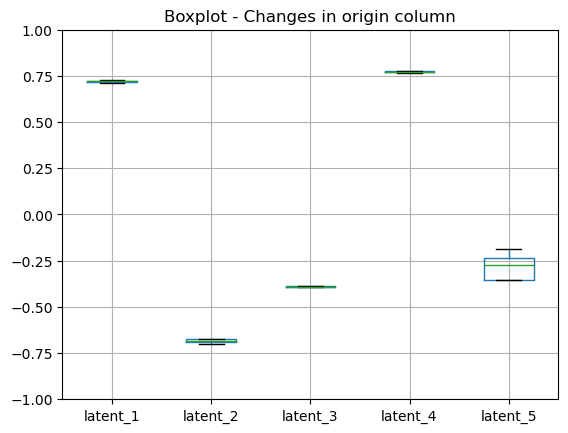

In [28]:
# Cambios en origen
df_predictions = pd.DataFrame(latent_space, columns = [f"latent_{i}" for i in range(1, latent_space.shape[1]+1)])

b_plot = df_predictions.boxplot()
plt.ylim(-1, 1)

plt.title("Boxplot - Changes in origin column")
plt.savefig(SAVE_PATH + "boxplot_origin_unlock.png", dpi=300, bbox_inches='tight')
b_plot.plot()

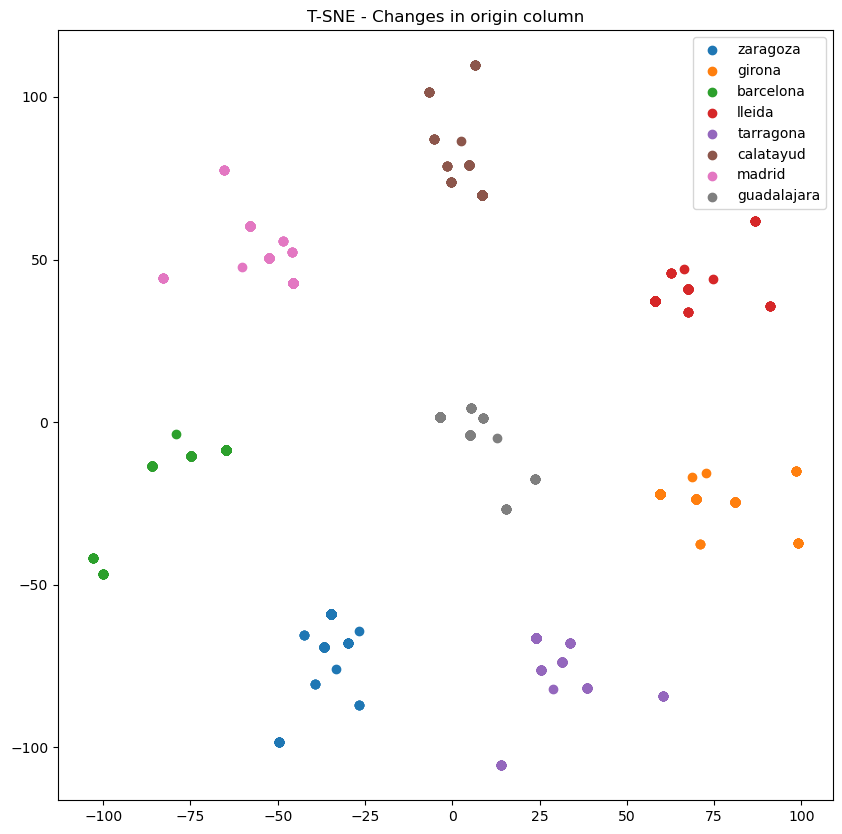

In [29]:
# T-SNE

tsne_plot(latent_space=latent_space,
          ae_embedding=locked_embedding,
          column='origin',
          title="T-SNE - Changes in origin column",
          file_name="tsne_origin_unlock")

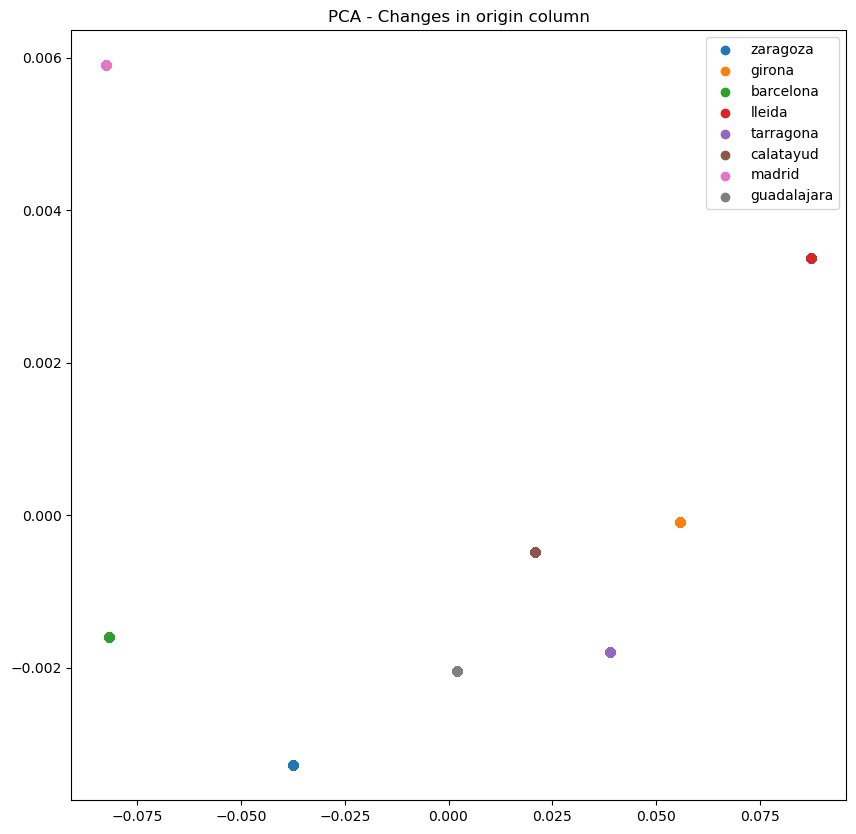

In [30]:
# PCA on latent space to analyze relationship between latent factors and input variables

pca_plot(latent_space=latent_space,
         ae_embedding=locked_embedding,
         column='origin',
         title="PCA - Changes in origin column",
         file_name="pca_origin_unlock")

In [160]:
latent_factors_range = []
num_iters = 30

df_latent = pd.DataFrame()
for i in range(1, num_iters+1):
    print(f"Iter {i}...")
    locked_dataframe = get_locked_dataframe(test_embedding.df, locked_columns=['origin', 'destination', 'date'], seed=i)
    locked_embedding = AutoencoderEmbedding(df=locked_dataframe, embedding_dim=EMBEDDING_DIM, noise=False)
    locked_latent_space = encoder_model.predict(x = locked_embedding.embedding_arrays, verbose=0)
    latent_space_range = pd.DataFrame(locked_latent_space).describe().loc[['min', 'max']]
    if i == 1:
        df_latent = pd.DataFrame(locked_latent_space, columns = [f"latent_{i}" for i in range(1, locked_latent_space.shape[1]+1)])
    else:
        df_latent = pd.concat([df_latent, pd.DataFrame(locked_latent_space, columns = [f"latent_{i}" for i in range(1, locked_latent_space.shape[1]+1)])], axis=0)
    print(latent_space_range)
    latent_factors_range.append(latent_space_range)

Iter 1...
            0         1         2         3         4
min  0.624256 -0.844073 -0.435603  0.710083  0.083165
max  0.719220  0.878215 -0.406149  0.764529  0.885991
Iter 2...
            0         1         2         3         4
min  0.640427 -0.804804 -0.432154  0.703794  0.075008
max  0.717344  0.768142 -0.417475  0.761734  0.626998
Iter 3...
            0         1         2         3         4
min  0.657734 -0.700735 -0.426191  0.691006 -0.189275
max  0.713302  0.350768 -0.392465  0.766081  0.121613
Iter 4...
            0         1         2         3         4
min  0.620116 -0.829009 -0.442280  0.701435  0.097538
max  0.705028  0.740542 -0.423668  0.750755  0.613412
Iter 5...
            0         1         2         3         4
min  0.640809 -0.817328 -0.439558  0.705132  0.095189
max  0.718654  0.752890 -0.420274  0.756658  0.614189
Iter 6...
            0         1         2         3         4
min  0.628514 -0.813683 -0.440128  0.699821  0.070973
max  0.712691  0.70121

In [161]:
latent_factors = [list(zip(*lfr.values)) for lfr in latent_factors_range]

df = pd.DataFrame(latent_factors, columns = [f'latent_{i}' for i in range(len(latent_factors[0]))])
display(df)

,latent_0,latent_1,latent_2,latent_3,latent_4
0,"(0.6242558360099792, 0.7192202806472778)","(-0.8440728187561035, 0.8782154321670532)","(-0.4356032609939575, -0.40614914894104004)","(0.7100831270217896, 0.7645288109779358)","(0.08316496759653091, 0.8859909176826477)"
1,"(0.6404273509979248, 0.717344343662262)","(-0.8048038482666016, 0.7681424021720886)","(-0.4321541488170624, -0.4174751043319702)","(0.7037941813468933, 0.7617344260215759)","(0.07500804960727692, 0.6269981265068054)"
2,"(0.6577337980270386, 0.7133023142814636)","(-0.7007350921630859, 0.35076791048049927)","(-0.42619121074676514, -0.39246460795402527)","(0.6910055875778198, 0.7660811543464661)","(-0.18927516043186188, 0.12161277234554291)"
3,"(0.6201159358024597, 0.705028235912323)","(-0.8290094137191772, 0.7405418753623962)","(-0.4422800838947296, -0.42366814613342285)","(0.7014349699020386, 0.7507551908493042)","(0.09753813594579697, 0.613412082195282)"
4,"(0.6408094167709351, 0.7186535000801086)","(-0.8173275589942932, 0.7528896927833557)","(-0.43955838680267334, -0.4202737510204315)","(0.7051319479942322, 0.7566580772399902)","(0.09518922865390778, 0.6141889095306396)"
5,"(0.6285142302513123, 0.7126909494400024)","(-0.813683271408081, 0.7012163996696472)","(-0.4401276409626007, -0.4164917767047882)","(0.6998211145401001, 0.7554986476898193)","(0.0709730014204979, 0.5473517179489136)"
6,"(0.6477077603340149, 0.7204848527908325)","(-0.688565194606781, 0.3195953965187073)","(-0.42037683725357056, -0.38783589005470276)","(0.6911512017250061, 0.7681867480278015)","(-0.2543680965900421, 0.07668215036392212)"
7,"(0.6411333084106445, 0.7165083289146423)","(-0.8113650679588318, 0.7235091924667358)","(-0.4414496123790741, -0.4225887358188629)","(0.7054134607315063, 0.7562297582626343)","(0.09660986810922623, 0.5834382772445679)"
8,"(0.6367943286895752, 0.7189854979515076)","(-0.812192440032959, 0.7348707914352417)","(-0.4420269727706909, -0.42361021041870117)","(0.7062265276908875, 0.7577875256538391)","(0.09150408208370209, 0.5731185078620911)"
9,"(0.6428954005241394, 0.734915554523468)","(-0.8351296186447144, 0.8439844250679016)","(-0.4761584997177124, -0.42851173877716064)","(0.6960155367851257, 0.7498939633369446)","(0.07635258138179779, 0.7724590301513672)"


In [162]:
def float_range_intersection(first_pair, second_pair):
    x0, y0 = first_pair
    x1, y1 = second_pair

    if y0 < x1 or y1 < x0:
      return None

    return max(x0, x1), min(y0, y1)

for col in df.columns:
    column_values = df[col].values
    for i in range(len(column_values)-1):
        if i == 0:
            first_pair = column_values[i]
        second_pair = column_values[i+1]
        intersection = float_range_intersection(first_pair, second_pair)
        if not intersection:
            print(f"Zero intersection for colum  {col}")
            break
        first_pair = intersection
    else:
        print(f"Final intersection for column {col}: {intersection}")

Final intersection for column latent_0: (0.6577337980270386, 0.6964240670204163)
Final intersection for column latent_1: (-0.6733318567276001, 0.23257794976234436)
Zero intersection for colum  latent_2
Final intersection for column latent_3: (0.7100831270217896, 0.7498939633369446)
Zero intersection for colum  latent_4


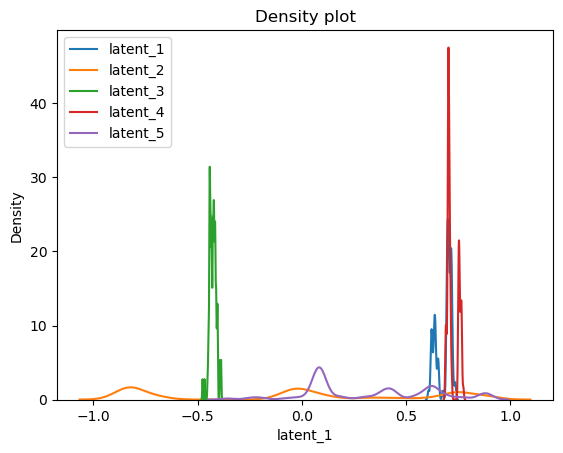

In [195]:
# Plot density of each column in df_latent dataframe
import seaborn as sns

for col in df_latent.columns:
    sns.kdeplot(df_latent[col], label=col)

plt.title(f"Density plot")
plt.legend()
plt.savefig(SAVE_PATH + f"density.png", dpi=300, bbox_inches='tight')
plt.show()

In [65]:
granularity = 0.05
bins = np.arange(-1, 1+granularity, granularity)
print(bins)

df_bins = pd.DataFrame()
for col in df_latent.columns:
    df_bins[f'bucket_{col}'] = pd.cut(df_latent[col], bins=bins)

print(df_bins.head())

[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]
  bucket_latent_1 bucket_latent_2 bucket_latent_3 bucket_latent_4  \
0     (0.65, 0.7]     (0.1, 0.15]   (-0.45, -0.4]     (0.7, 0.75]   
1     (0.7, 0.75]     (0.1, 0.15]   (-0.45, -0.4]     (0.7, 0.75]   
2     (0.65, 0.7]     (0.1, 0.15]   (-0.45, -0.4]     (0.7, 0.75]   
3     (0.65, 0.7]     (0.1, 0.15]   (-0.45, -0.4]     (0.7, 0.75]   
4     (0.65, 0.7]     (0.1, 

In [84]:
df_intervalos = pd.DataFrame()

for col in df_bins.columns:
    df_intervalos[f"count_{col}"] = df_bins.groupby(col).size().sort_index()

df_intervalos.index.name = 'bins'
print(df_intervalos)

Empty DataFrame
Columns: []
Index: []
Here
                   count_bucket_latent_1  count_bucket_latent_2  \
bins                                                              
(-1.0, -0.95]                          0                      0   
(-0.95, -0.9]                          0                      0   
(-0.9, -0.85]                          0                   4176   
(-0.85, -0.8]                          0                   7419   
(-0.8, -0.75]                          0                   2300   
(-0.75, -0.7]                          0                   1883   
(-0.7, -0.65]                          0                   5222   
(-0.65, -0.6]                          0                      0   
(-0.6, -0.55]                          0                      0   
(-0.55, -0.5]                          0                      0   
(-0.5, -0.45]                          0                      0   
(-0.45, -0.4]                          0                      0   
(-0.4, -0.35]      

In [164]:
xdat = []
ydat = []
for i, col in enumerate(df_latent.columns, start=1):
    xdat.extend([i for _ in range(df_latent.shape[0])])
    ydat.extend(df_latent[col].values)

x_dat = np.array(xdat)
y_dat = np.array(ydat)

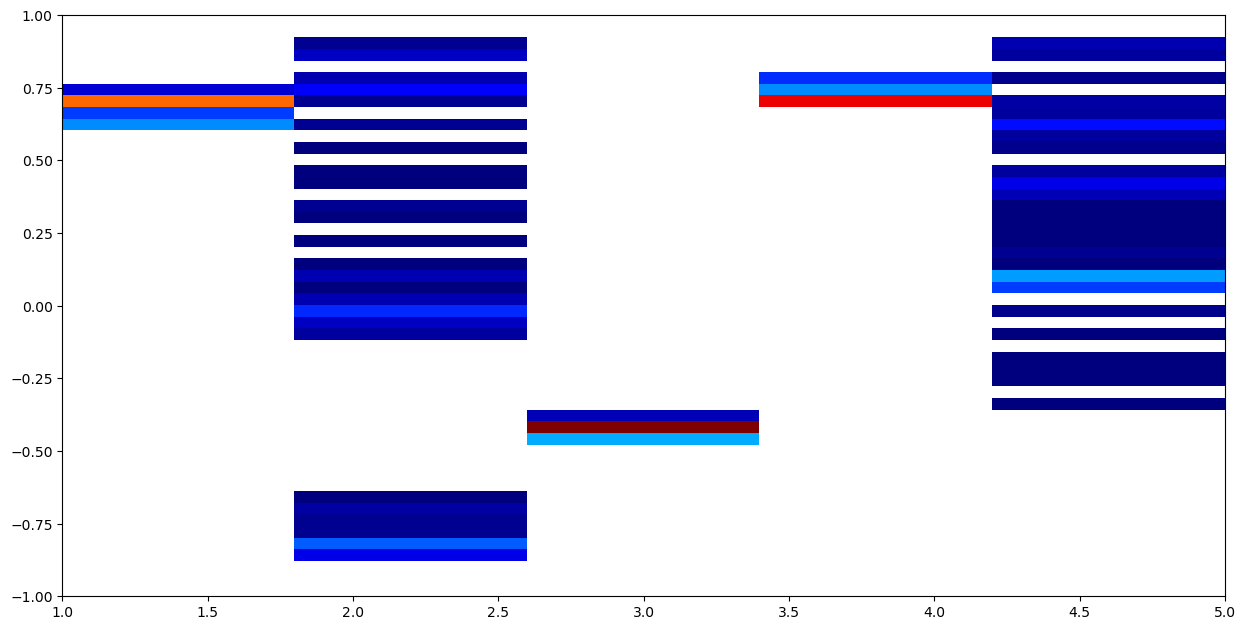

In [165]:
import scipy

#histogram definition
xyrange = [[1,5],[-1,1]] # data range
bins = [5,50] # number of bins
thresh = 3  #density threshold

#data definition
N = 10000
#xdat, ydat = np.random.normal(3, 0.8, size=N), np.random.normal(0, 0.3, size=N)

# histogram the data
hh, locx, locy = np.histogram2d(xdat, ydat, range=xyrange, bins=bins)
posx = np.digitize(xdat, locx)
posy = np.digitize(ydat, locy)

#select points within the histogram
ind = (posx > 0) & (posx <= bins[0]) & (posy > 0) & (posy <= bins[1])
hh[hh < thresh] = np.nan # fill the areas with low density by NaNs

plt.figure(figsize=(15,15))

plt.imshow(np.flipud(hh.T), cmap='jet', extent=np.array(xyrange).flatten(), interpolation='none', origin='upper')
#plt.colorbar()
plt.show()

In [41]:
# Calculate Pearson correlation
pearson_corr = []
p_values_pearson = []
for i in range(latent_dim):
    correlation, p_value = pearsonr(latent_space[:, i], test_embedding.df_embedding['origin'])
    pearson_corr.append(correlation)
    p_values_pearson.append(p_value)

# Calculate Spearman correlation
spearman_corr = []
p_values_spearman = []
for i in range(latent_dim):
    correlation, p_value = spearmanr(latent_space[:, i], test_embedding.df_embedding['origin'])
    spearman_corr.append(correlation)
    p_values_spearman.append(p_value)

# Create dataframe with results
resultados_correlacion = pd.DataFrame({'Latent factor': range(1, 6),
                                      'Pearson correlation': pearson_corr,
                                      'Pearson p-value': p_values_pearson,
                                      'Spearman correlation': spearman_corr,
                                      'Spearman p-valus': p_values_spearman})

# Print results
display(resultados_correlacion)
print()

AttributeError: 'bool' object has no attribute 'all'

In [42]:
df_test = test_embedding.df.copy()
df_test['date'] = df_test['date'].apply(lambda x: np.float32(int(datetime.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second).total_seconds())
))
df_test = pd.get_dummies(df_test, columns=['origin', 'destination', 'user_pattern', 'date'])

# df_test to numpy array
df_test = df_test.to_numpy()

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_test,
                                                    latent_space,
                                                    test_size=0.2,
                                                    random_state=0)

# Train MLPRegressor
regressor = MLPRegressor(hidden_layer_sizes=(100, 100, 100),
                         activation='relu',
                         solver='adam',
                         max_iter=1000,
                         random_state=0).fit(X_train, y_train)

# Evaluate MLPRegressor
print(f"Train score: {regressor.score(X_train, y_train)}")
print(f"Test score: {regressor.score(X_test, y_test)}")

Train score: -0.36646614267107613
Test score: -2.858258681892062
